##  Modelo de Machine Learning com Random Forest

Este notebook implementa e avalia um **classificador Random Forest** aplicado a dados financeiros, com o objetivo de **prever a direção do próximo candle** (alta ou baixa).  

A previsão gerada pelo modelo pode ser utilizada como **filtro adicional** em estratégias de **trend following** já existentes (como SMA Cross), ajudando a reduzir falsos sinais de entrada e melhorar a robustez da estratégia.

---

## Objetivo

> Este notebook tem como objetivo **explorar e aplicar um modelo de Machine Learning** (Random Forest) para prever a direção do próximo candle (alta ou baixa).  
>
> - Utilizamos features derivadas de indicadores técnicos (RSI, SMA, volatilidade, retornos).  
> - O modelo de classificação tem como propósito servir como **filtro auxiliar** para estratégias de trend following.  
> - Métricas principais avaliadas: **Acurácia, F1-Score, Matriz de Confusão e ROC-AUC**.  
> - Resultados iniciais mostram desempenho próximo ao aleatório, mas com potencial de ajuste e otimização.


In [20]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [21]:
def rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(window).mean()
    roll_down = down.rolling(window).mean()
    rs = roll_up / roll_down
    return 100 - (100 / (1 + rs))

def add_features(df):
    df['return'] = df['Close'].pct_change()
    df['cum_return'] = (1 + df['return']).cumprod()

    df['SMA20'] = df['Close'].rolling(20).mean()
    df['SMA50'] = df['Close'].rolling(50).mean()
    df['RSI14'] = rsi(df['Close'], 14)

    df['volatility20'] = df['return'].rolling(20).std()
    df['bollinger_upper'] = df['SMA20'] + 2*df['volatility20']
    df['bollinger_lower'] = df['SMA20'] - 2*df['volatility20']

    df = df.dropna()
    return df


In [ ]:
TICKER = "PETR4.SA"
START = "2020-01-01"
END = "2025-01-01"

df = yf.download(TICKER, start=START, end=END)
df = add_features(df)

df['target'] = (df['return'].shift(-1) > 0).astype(int)
df = df.dropna()

X = df[['return', 'cum_return', 'SMA20', 'SMA50', 'RSI14', 'volatility20', 'bollinger_upper', 'bollinger_lower']]
y = df['target']


C:\Users\marcu\AppData\Local\Temp\ipykernel_996\1306264760.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END)
[*********************100%***********************]  1 of 1 completed


In [23]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42, class_weight="balanced"))
])

tscv = TimeSeriesSplit(n_splits=5)
roc_auc_scores = cross_val_score(pipe, X, y, cv=tscv, scoring="roc_auc")
print(f"TimeSeriesSplit ROC-AUC (mean±std): {roc_auc_scores.mean():.3f} ± {roc_auc_scores.std():.3f}")


TimeSeriesSplit ROC-AUC (mean±std): 0.528 ± 0.056


Accuracy: 0.585
ROC-AUC: 0.6326632663266326
              precision    recall  f1-score   support

           0       0.55      0.94      0.69        99
           1       0.80      0.24      0.37       101

    accuracy                           0.58       200
   macro avg       0.67      0.59      0.53       200
weighted avg       0.67      0.58      0.53       200



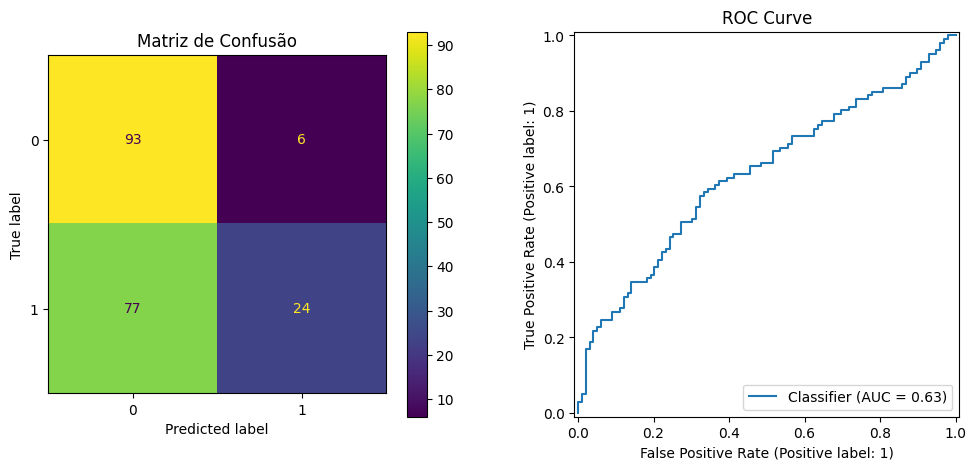

In [25]:
X_train, X_test = X.iloc[:-200], X.iloc[-200:]
y_train, y_test = y.iloc[:-200], y.iloc[-200:]

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

fig, axes = plt.subplots(1,2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], cmap="viridis")
axes[0].set_title("Matriz de Confusão")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("ROC Curve")

plt.show()
